# From pulses to gates
- Rabi flop
    - Visualization on the Bloch sphere
- Rydberg blockade

In [1]:
import numpy as np

from rsp.core.experiment import AtomSystem, ExperimentSetup

# Loading experimental settings
exp = ExperimentSetup.fromFile('hardware_config.json')

# Initializing the atom system
lattice_unit = 3e-6

atomsys = AtomSystem()
atom = exp.get_atom()

positions = {'A': lattice_unit*np.array([0,0,0]),}

# loading the atom system with atoms and respective positions
for label, pos in positions.items():
    atomsys.add_atom(label, atom, pos)


Rabi rotations

In [2]:
from rsp.core.circuit.pulses import PulsedGate
from pulser.pulse import Pulse
from pulser.waveforms import ConstantWaveform

def const_amplitude(transition, amplitude, detuning=0):
    rabi_freq = exp.rabi_freq[{'01':('0','1'), '1r':('1','r')}[transition]]
    duration = int(1/rabi_freq * 1e9)
    amp_wf = ConstantWaveform(duration, amplitude)
    det_wf = ConstantWaveform(duration, -detuning)
    
    return Pulse(amplitude=amp_wf, detuning=det_wf, phase=0)

pulseX = PulsedGate()
pulseX.new_channel('clock', ('0', '1'))
pulseX.add_pulse(pulse=const_amplitude('01', 6*np.pi), channel='clock', target=0)
pulseX._compile_pulses(1e-9)

In [3]:
from rsp.core.circuit import QuantumCircuit
from rsp.core.simulation import Simulator

qc = QuantumCircuit()
qc.add_operation(pulseX, ['A'])

sim = Simulator(exp, atomsys)

sim.run_circuit(qc, save_states=True)

/home/raul/Projects/rsp/src/rsp/core/simulation/simulator.py:745: UserWarning: Running full evolution, cache checks failed
  warnings.warn("Running full evolution,"


{}

Visualizing the rabi oscillations, from $|0\rangle$ to $|1\rangle$ 

$6\pi$ corresponds to 3 full rotations

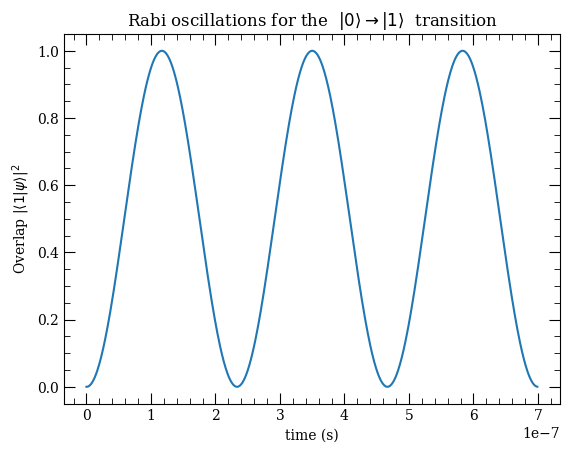

In [4]:


from qutip import ket, Bloch, basis, qeye
import matplotlib.pyplot as plt

overlap = []
for psi in sim.saved_states:
    overlap.append( np.abs((ket('1', 3).dag() * psi).tr())**2)
plt.plot(sim.saved_states_times, overlap)
plt.ylabel(r'Overlap $ |\langle 1|\psi\rangle|^2 $')
plt.xlabel('time (s)')
plt.title(r"Rabi oscillations for the  $|0\rangle\rightarrow|1\rangle$  transition")
plt.show()


Plotting the path along the bloch sphere

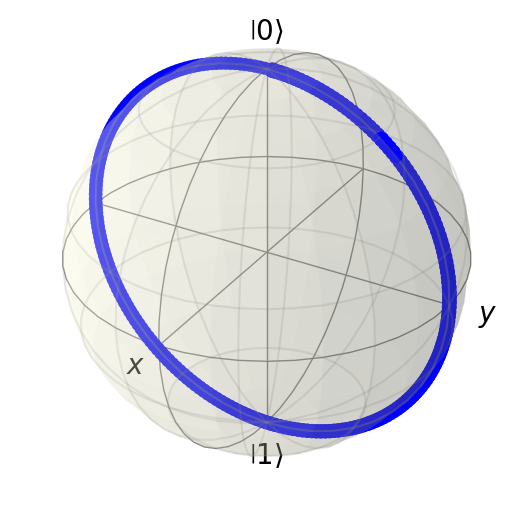

In [5]:
import qutip 
from qutip import ket, Bloch, basis, qeye

two_projector = ket('0', 2) * ket('0', 3).dag() +  ket('1', 2) * ket('1', 3).dag()
b = qutip.Bloch()

b.point_color = ['b']*len(sim.saved_states)
b.point_marker = ['o']*len(sim.saved_states)
b.point_alpha = [*np.linspace(0.1, 1, len(sim.saved_states))]
b.point_size = [*np.linspace(10, 100, len(sim.saved_states))]

b.sphere_color = '#FFFFDD'

for psi in sim.saved_states:
    b.add_states(two_projector*psi, kind='point',)
b.show()

Lets do a z rotation and try to get the state $|+\rangle=\frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)$ 

In [6]:
qc.reset()

pulseX = PulsedGate()
pulseX.new_channel('clock', ('0', '1'))
pulseX.add_pulse(pulse=const_amplitude('01', 1/2*np.pi), channel='clock', target=0)
pulseX._compile_pulses(1e-9)

pulseZ = PulsedGate()
pulseZ.new_channel('clock', ('0', '1'))
pulseZ.add_pulse(pulse=const_amplitude('01', 0, 1/2*np.pi), channel='clock', target=0)
pulseZ._compile_pulses(1e-9)

qc.add_operation(pulseX, ['A'])
qc.add_operation(pulseZ, ['A'])

sim = Simulator(exp, atomsys)

sim.run_circuit(qc, save_states=True)

{}

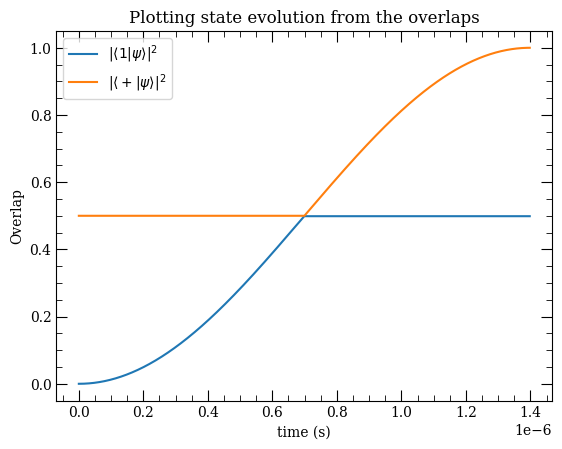

In [7]:
from qutip import ket, Bloch, basis, qeye
import matplotlib.pyplot as plt

overlapX = []
overlapP = []
ket_plus = (ket('0', 3)+ket('1', 3))/np.sqrt(2)
for psi in sim.saved_states:
    overlapX.append( np.abs((ket('1', 3).dag() * psi).tr())**2 )
    overlapP.append( np.abs((ket_plus.dag() * psi).tr())**2 )

plt.plot(sim.saved_states_times, overlapX, label=r'$|\langle 1|\psi\rangle|^2$')
plt.plot(sim.saved_states_times, overlapP, label=r'$|\langle +|\psi\rangle|^2$')

plt.ylabel(r'Overlap')
plt.xlabel('time (s)')
plt.title(r"Plotting state evolution from the overlaps")
plt.legend()
plt.show()

Viewing the evolution on the Bloch sphere

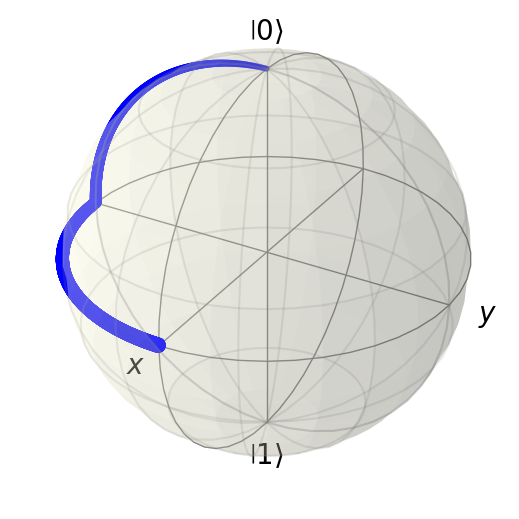

In [8]:
import qutip 
from qutip import ket, Bloch, basis, qeye

two_projector = ket('0', 2) * ket('0', 3).dag() +  ket('1', 2) * ket('1', 3).dag()
b = qutip.Bloch()

b.point_color = ['b']*len(sim.saved_states)
b.point_marker = ['o']*len(sim.saved_states)
b.point_alpha = [*np.linspace(0.1, 1, len(sim.saved_states))]
b.point_size = [*np.linspace(10, 100, len(sim.saved_states))]

b.sphere_color = '#FFFFDD'

for psi in sim.saved_states:
    b.add_states(two_projector*psi, kind='point',)
b.show()

## Building gates for quantum computation

Lets build some quantum gates

In [9]:

gateX01 = PulsedGate()
gateX01.new_channel('clock', ('0', '1'))
# Start of gate X01
gateX01.add_pulse(pulse=const_amplitude('01', np.pi), channel='clock', target=0) # solution: remove for workshop
# end of gate X01

gateSX = PulsedGate() # sqrt of X
gateSX.new_channel('clock', ('0', '1'))
# Start of gate SX
gateSX.add_pulse(pulse=const_amplitude('01', 1/2*np.pi), channel='clock', target=0)
# end of gate SX


gateZ01 = PulsedGate()
gateZ01.new_channel('clock', ('0', '1'))
# Start of gate Z01
gateZ01.add_pulse(pulse=const_amplitude('01', 0, np.pi), channel='clock', target=0)
# end of gate Z01


gateS = PulsedGate() # sqrt of Z
gateS.new_channel('clock', ('0', '1'))
# Start of gate S
gateS.add_pulse(pulse=const_amplitude('01', 0, 1/2*np.pi), channel='clock', target=0)
# end of gate S


gateT = PulsedGate() # sqrt of S
gateT.new_channel('clock', ('0', '1'))
# Start of gate S
gateT.add_pulse(pulse=const_amplitude('01', 0, 1/4*np.pi), channel='clock', target=0) # solution: remove for workshop
# end of gate S


gateX1r = PulsedGate()
gateX1r.new_channel('ryd', ('1', 'r'))
# Start of gate X1r
gateX1r.add_pulse(pulse=const_amplitude('1r', np.pi), channel='ryd', target=0) # solution: remove for workshop
# end of gate X1r

The gates can be added to the quantum circuit dictionary so that you may refer to them with their name

In [10]:
qc = QuantumCircuit()
qc.add_to_dictionary(gateX01, 'X01')
qc.add_to_dictionary(gateSX, 'SX')
qc.add_to_dictionary(gateZ01, 'Z')
qc.add_to_dictionary(gateS, 'S')
qc.add_to_dictionary(gateT, 'T')
qc.add_to_dictionary(gateX1r, 'X1r')

Lets use these operations

In [11]:
qc.reset()
# qc.add_operation('X01', ['A'])

qc.add_operation('S', ['A'])
qc.add_operation('SX', ['A'])
qc.add_operation('S', ['A'])


qc.add_operation('T', ['A'])
qc.add_operation('SX', ['A'])
qc.add_operation('Z', ['A'])
qc.add_operation('X1r', ['A'])


ket_plus = (ket('0', 3) + ket('1', 3))/np.sqrt(2)
ket_minus = (ket('0', 3) - ket('1', 3))/np.sqrt(2)

sim = Simulator(exp, atomsys)

sim.run_circuit(qc, save_states=True)


{}

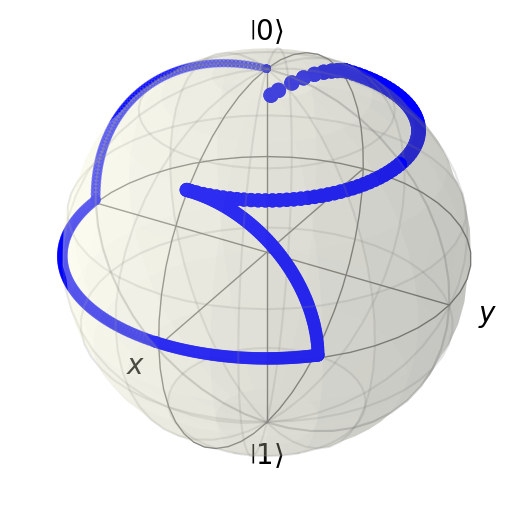

In [12]:
import qutip 
from qutip import ket, Bloch, basis, qeye

two_projector = ket('0', 2) * ket('0', 3).dag() +  ket('1', 2) * ket('1', 3).dag()
b = qutip.Bloch()

b.point_color = ['b']*len(sim.saved_states)
b.point_marker = ['o']*len(sim.saved_states)
b.point_alpha = [*np.linspace(0.1, 1, len(sim.saved_states))]
b.point_size = [*np.linspace(10, 100, len(sim.saved_states))]

b.sphere_color = '#FFFFDD'

for psi in sim.saved_states:
    b.add_states(two_projector*psi, kind='point',)
b.show()

So far we have looked into single qubit rotations on a single atom. Lets see what we can do with another one

In [13]:
sim.saved_states[-1]

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.84730969-0.35633947j]
 [-0.01853686+0.00864792j]
 [ 0.16627164+0.35640401j]]

# Demo: Quantum State Teleportation 